# Differentiable Forwards Modelled Interferrometry

This little tutorial is designed to give an overview of how to forwards-model fit interferrometric observables directly to data, including aberratios and detector effects.

In [1]:
import jax
import jax.numpy as np
import dLux as dl
import dLux.utils as dlu
import zodiax as zdx

jax.config.update("jax_enable_x64", True)

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120

## Get the Data

In [2]:
data_path = "/Users/louis/Data/JWST/COM1093/stage2/"

import os
from astropy.io import fits

file_names = os.listdir(data_path)

ABDOR = []
HD37093 = []
HD36805 = []
for name in file_names:
    # if name.endswith("calints.fits"):
    if name.endswith("cal.fits"):
        file = fits.open(data_path + name)
        targ = file[0].header["TARGPROP"]

        # Skip TAQ files
        if file[0].header["EXP_TYPE"] != "NIS_AMI":
            continue

        # Split into each target
        if targ == "AB-DOR":
            ABDOR.append(file)
        elif targ == "HD-37093":
            HD37093.append(file)
        elif targ == "HD-36805":
            HD36805.append(file)

In [3]:
len(ABDOR), len(HD37093), len(HD36805)

(13, 11, 31)

In [4]:
keys = [
    "TARGPROP",
    "TARGNAME",
    "DATAMODL",
    "INSTRUME",
    "DETECTOR",
    "FILTER",
    "PUPIL",
    "EXP_TYPE",
    "PATTTYPE",
    "APERNAME",
    "SUBARRAY",
]


star_names = ["ABDOR", "HD37093", "HD36805"]
star_files = [ABDOR, HD37093, HD36805]
for star, name in zip(star_files, star_names):
    print()
    print("====================")
    print(name)

    unique_keys = []
    common_keys = []
    for key in keys:
        values = set([f[0].header[key] for f in star])
        vals_str = ", ".join([f"{val}" for val in values])
        print(f"  {key}: {vals_str}")


ABDOR
  TARGPROP: AB-DOR
  TARGNAME: HD 36705
  DATAMODL: ImageModel
  INSTRUME: NIRISS
  DETECTOR: NIS
  FILTER: F480M, F430M, F380M
  PUPIL: NRM
  EXP_TYPE: NIS_AMI
  PATTTYPE: AMI, NONE
  APERNAME: NIS_AMI1
  SUBARRAY: SUB80

HD37093
  TARGPROP: HD-37093
  TARGNAME: HD 37093
  DATAMODL: ImageModel
  INSTRUME: NIRISS
  DETECTOR: NIS
  FILTER: F480M, F430M, F380M
  PUPIL: NRM
  EXP_TYPE: NIS_AMI
  PATTTYPE: AMI, NONE
  APERNAME: NIS_AMI1
  SUBARRAY: SUB80

HD36805
  TARGPROP: HD-36805
  TARGNAME: HD 36805
  DATAMODL: ImageModel
  INSTRUME: NIRISS
  DETECTOR: NIS
  FILTER: F480M, F430M, F380M
  PUPIL: NRM
  EXP_TYPE: NIS_AMI
  PATTTYPE: AMI, NONE
  APERNAME: NIS_AMI1
  SUBARRAY: SUB80


In [5]:
ABDOR[0].info()

Filename: /Users/louis/Data/JWST/COM1093/stage2/jw01093013001_03103_00001_nis_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     328   ()      
  1  SCI           1 ImageHDU        73   (80, 80)   float32   
  2  ERR           1 ImageHDU        10   (80, 80)   float32   
  3  DQ            1 ImageHDU        11   (80, 80)   int32 (rescales to uint32)   
  4  VAR_POISSON    1 ImageHDU         9   (80, 80)   float32   
  5  VAR_RNOISE    1 ImageHDU         9   (80, 80)   float32   
  6  VAR_FLAT      1 ImageHDU         9   (80, 80)   float32   
  7  ASDF          1 BinTableHDU     11   1R x 1C   [23357B]   


In [6]:
def plot_image(fits_file, idx=0):
    def getter(file, k):
        if file[k].data.ndim == 2:
            return file[k].data
        else:
            return file[k].data[idx]

    plt.figure(figsize=(15, 4))

    plt.suptitle(fits_file[1].data.shape)

    plt.subplot(1, 3, 1)
    plt.title("SCI")
    plt.imshow(getter(fits_file, 1))
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.title("ERR")
    plt.imshow(getter(fits_file, 2))
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.title("DQ")
    plt.imshow(getter(fits_file, 3))
    plt.colorbar()

    plt.tight_layout()
    plt.show()


def compare(arr1, arr2, k=0, normres=True):
    arr1 = np.array(arr1).astype(float)
    arr2 = np.array(arr2).astype(float)

    if arr1.ndim != 2 or arr2.ndim != 2:
        raise ValueError("Arrays must be 2D")

    if arr1.shape != arr2.shape:
        raise ValueError("Arrays must have same shape")

    c = arr1.shape[0] // 2
    s = c - k
    cut = slice(c - s, c + s, 1)

    res = arr1 - arr2

    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(arr1[cut, cut])
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.imshow(arr2[cut, cut])
    plt.colorbar()

    v = np.nanmax(np.abs(res[cut, cut]))
    plt.subplot(1, 3, 3)
    plt.imshow(res[cut, cut], cmap="seismic", vmin=-v, vmax=v)
    plt.colorbar()

    plt.tight_layout()
    plt.show()


def convert_adjacent_to_true(bool_array):
    trues = np.array(np.where(bool_array))
    trues = np.swapaxes(trues, 0, 1)
    for i in range(len(trues)):
        y, x = trues[i]
        bool_array = bool_array.at[y, x + 1].set(True)
        bool_array = bool_array.at[y, x - 1].set(True)
        bool_array = bool_array.at[y + 1, x].set(True)
        bool_array = bool_array.at[y - 1, x].set(True)
    return bool_array


# def imshow(fig, *args, **kwargs):
#     if "cmap" in kwargs:
#         cmap.set_bad(color="gray")
#     fig.imshow(*args, **kwargs)

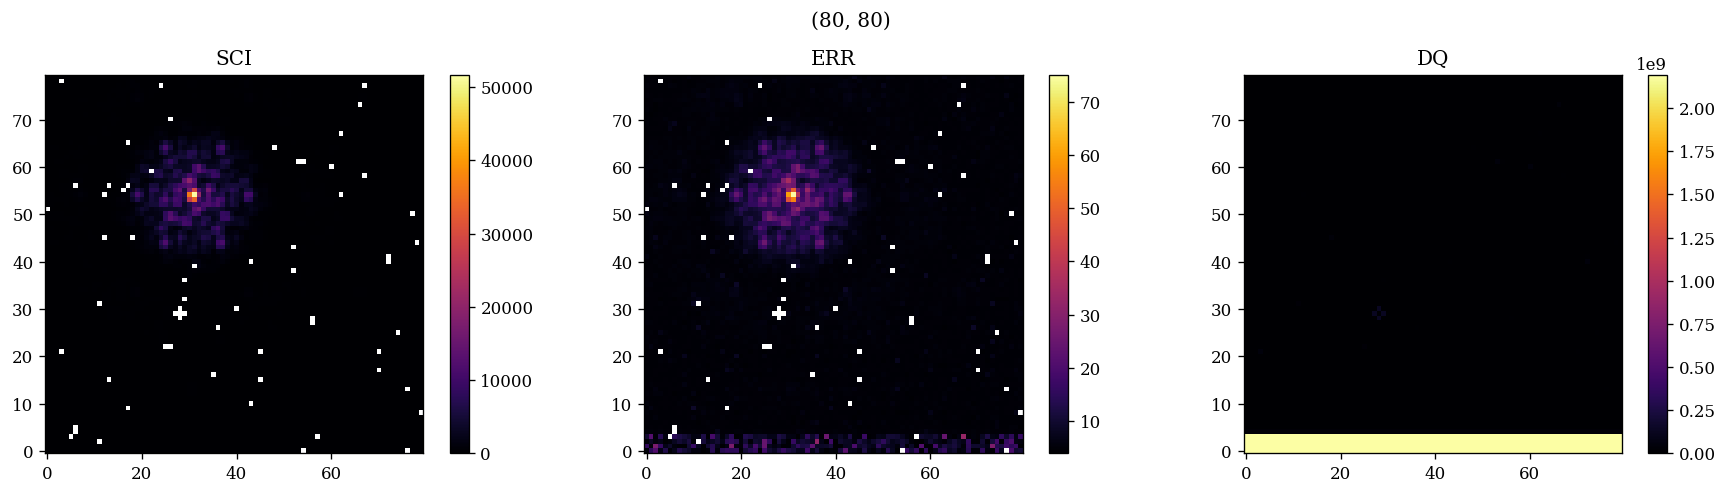

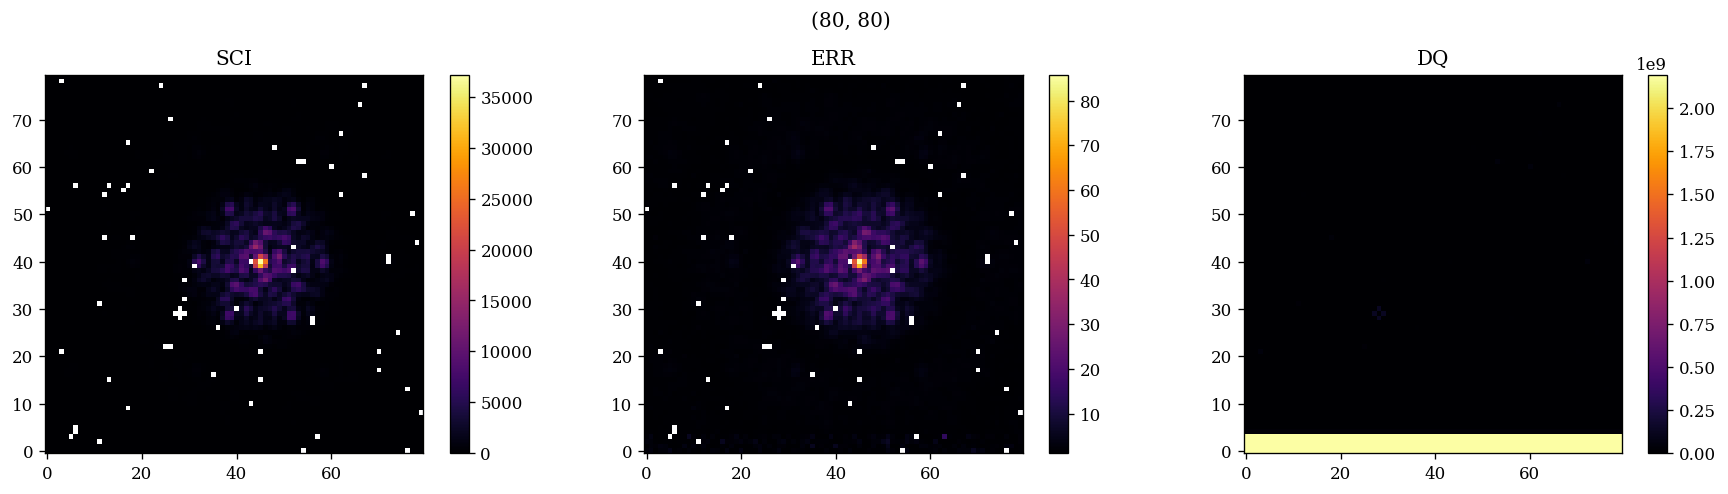

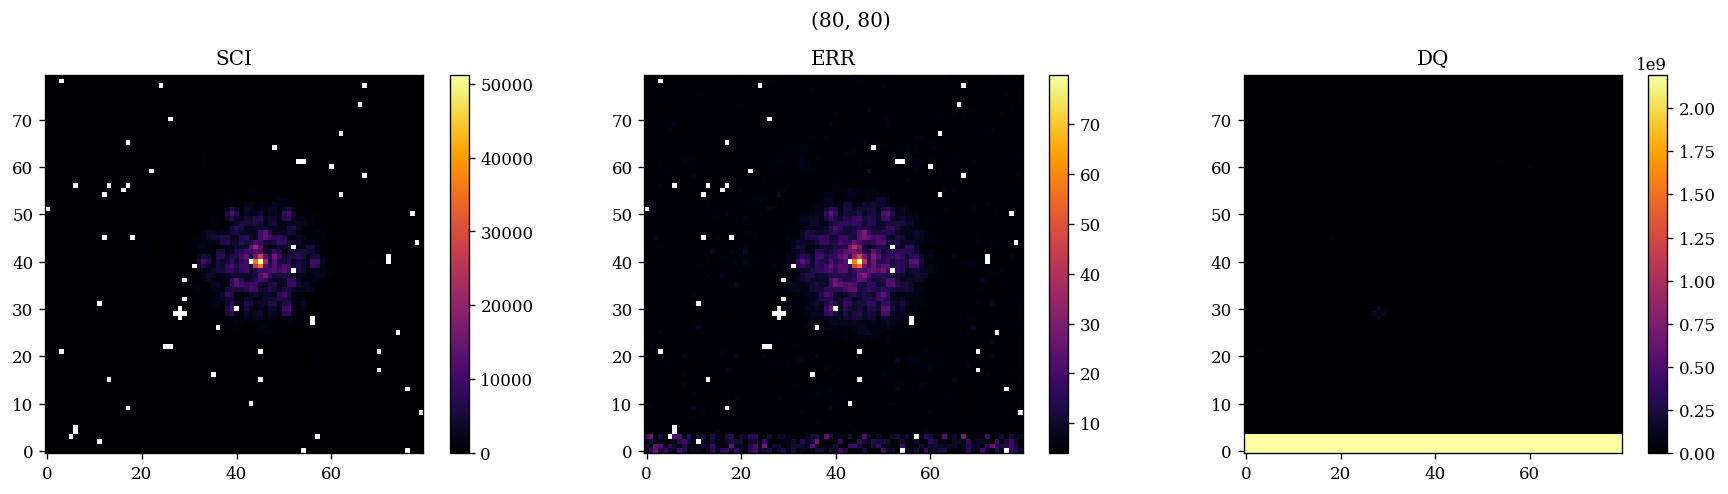

In [7]:
for file in ABDOR[:3]:
    plot_image(file, 0)

In [8]:
instrument = "INSTRUME"
detector = "DETECTOR"
filter = "FILTER"
pupil = "PUPIL"
aperture = "APERNAME"

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-062 CANNOT BE CHECKED AGAINST ONLINE VERSION


iterating query, tdelta=3.0

MAST OPD query around UTC: 2022-06-05T13:41:13.401
                        MJD: 59735.570293993056

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022060402-NRCA3_FP1-1.fits
	Date (MJD):	 59733.8175
	Delta time:	 -1.7528 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022060602-NRCA3_FP1-1.fits
	Date (MJD):	 59735.9130
	Delta time:	 0.3427 days
User requested choosing OPD time closest in time to 2022-06-05T13:41:13.401, which is R2022060602-NRCA3_FP1-1.fits, delta time 0.343 days
Importing and format-converting OPD from /Users/louis/Data//webbpsf-data/MAST_JWST_WSS_OPDs/R2022060602-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
2022-06-05T13:41:13.401000


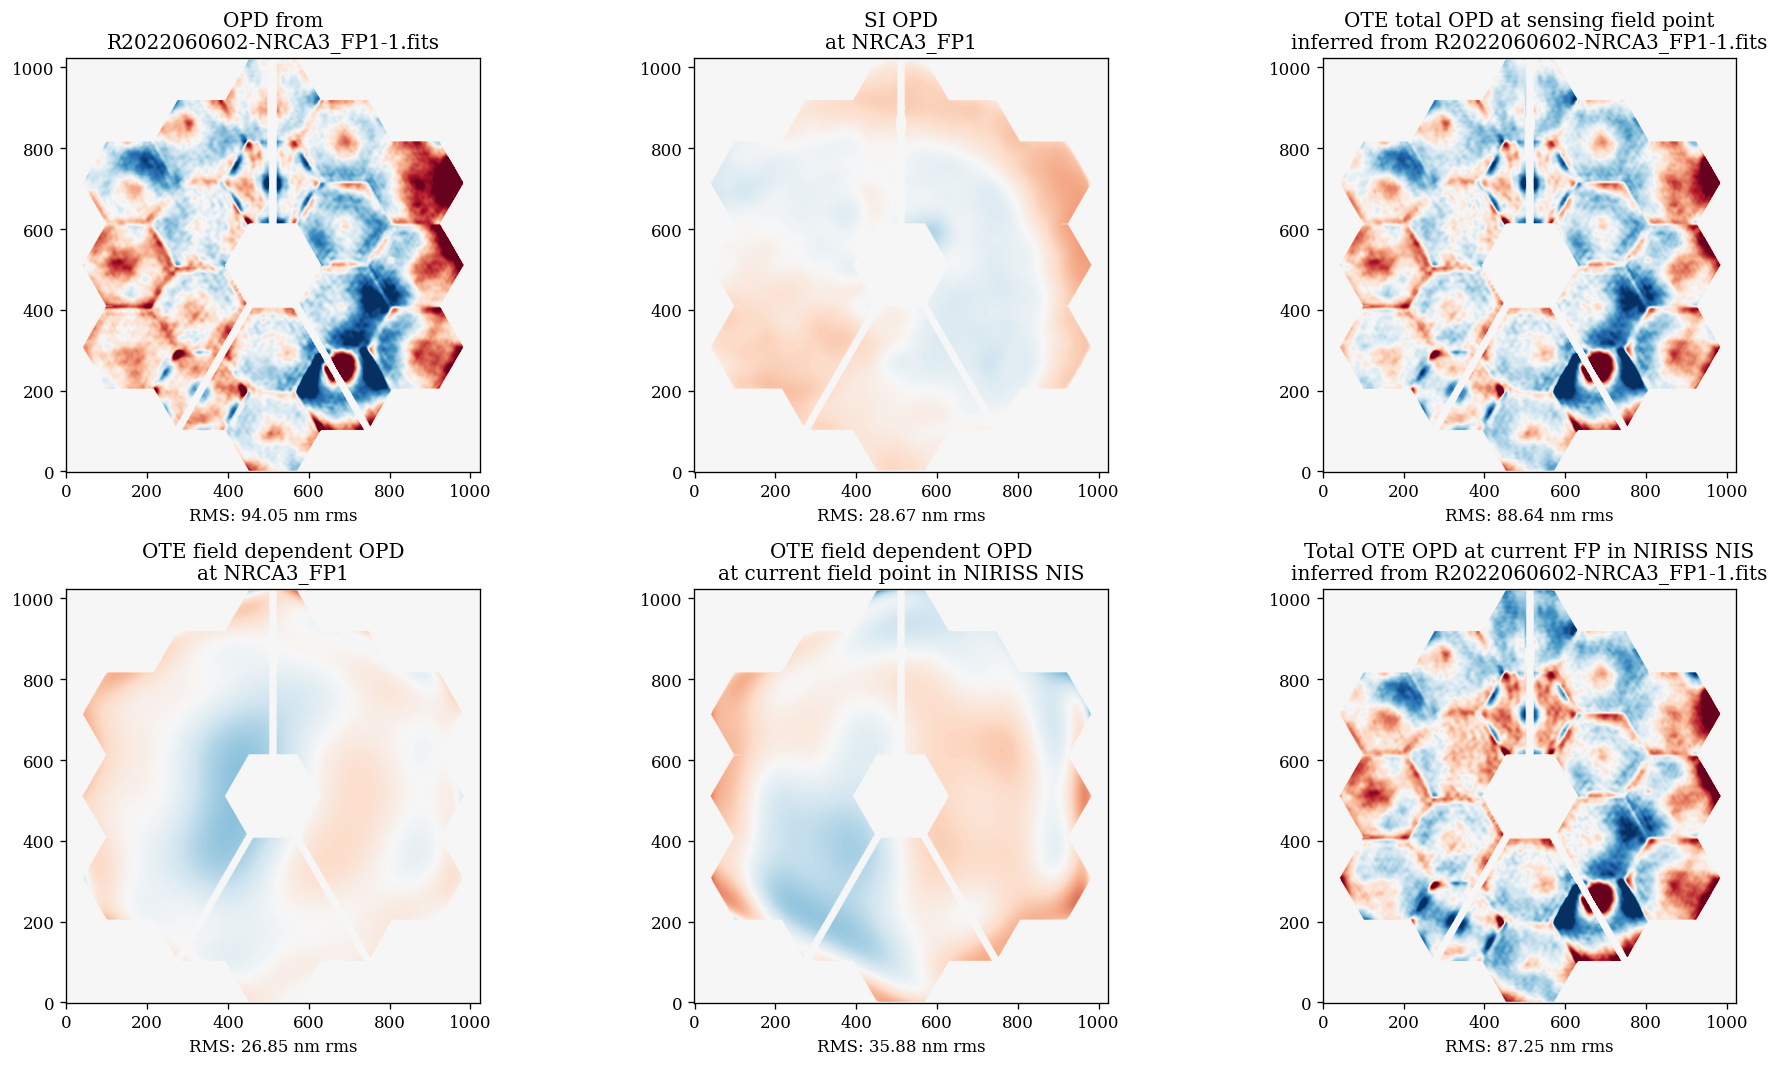

In [9]:
import webbpsf
import datetime

name = "jw01093012001_03102_00001_nis_cal.fits"
file = fits.open(data_path + name)

niriss = webbpsf.NIRISS()
niriss.filter = file[0].header[filter]
niriss.aperturename = file[0].header[aperture]

if file[0].header[pupil] == "NRM":
    pupil_in = "MASK_NRM"
else:
    pupil_in = file[0].header[pupil]
niriss.pupil_mask = pupil_in

# Set WFS data
d1 = datetime.datetime.fromisoformat(file[0].header["DATE-BEG"])
d2 = datetime.datetime.fromisoformat(file[0].header["DATE-END"])
time = (d1 + (d2 - d1) / 2).isoformat()  # Weirdness here because you cant add datetimes
niriss.load_wss_opd_by_date(time, plot=True)
print(time)

# Calculate data to ensure things are populated correctly
psf_fits = niriss.calc_psf()

# Get modelling wavelengths
wls, wgts = [], []
for i in range(9):
    wls.append(psf_fits[0].header[f"WAVE{i}"])
    wgts.append(psf_fits[0].header[f"WGHT{i}"])
wls = np.array(wls)
wgts = np.array(wgts)

In [10]:
import dLuxWebbpsf as dlw

if file[0].header[pupil] == "NRM":
    pupil_in = "MASK_NRM"
else:
    pupil_in = file[0].header[pupil]

tel = dlw.NIRISS(
    filter=file[0].header[filter],
    aperture=file[0].header[aperture],
    detector=file[0].header[detector],
    pupil_mask=pupil_in,
)

planes = niriss.optsys.planes
tel = tel.set("pupil.opd", np.array(planes[0].__dict__["opd"]))
tel = tel.set("aberrations.opd", np.array(planes[2].__dict__["opd"]))
# print(tel)

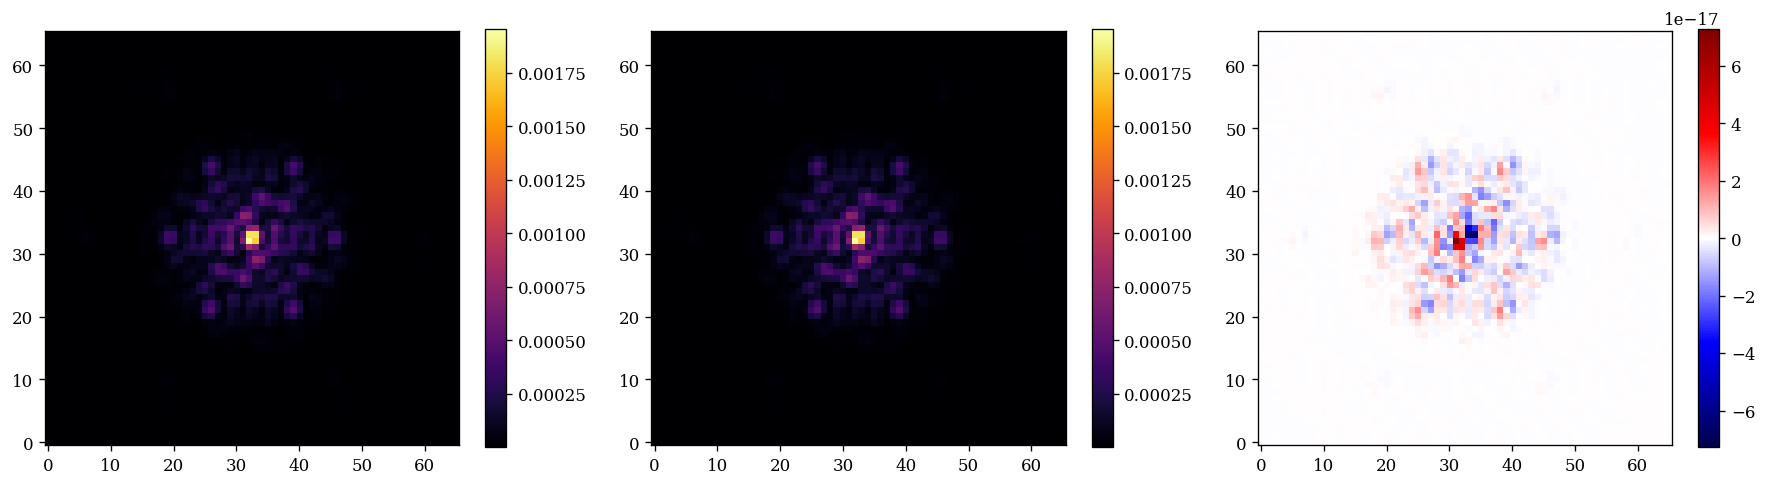

In [11]:
compare(psf_fits[-1].data, tel.model(), 5)

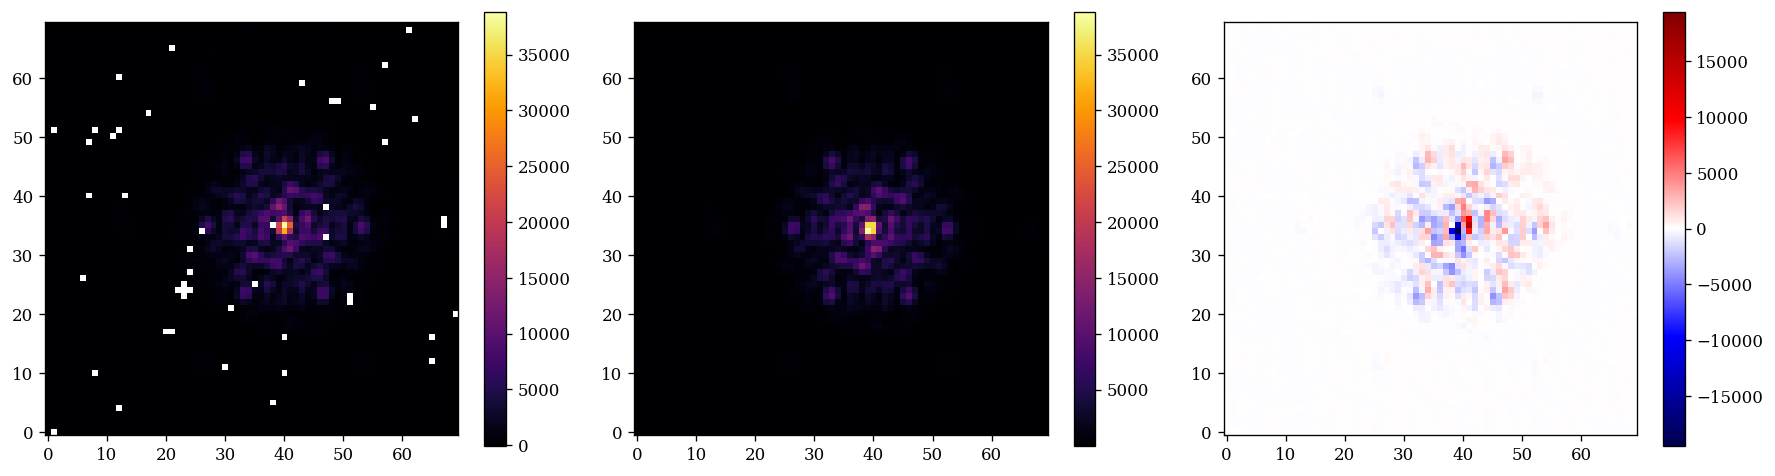

In [12]:
# Enforce correct npix
im = np.array(file[1].data).astype(float)
tel = tel.set("psf_npixels", im.shape[0])

# Enforce initial position
pscale = tel.psf_pixel_scale
max_idx = np.array(np.where(im == np.nanmax(im))).squeeze()
pos = np.roll(dlu.arcsec2rad(pscale) * (max_idx - im.shape[0] // 2), 1)
tel = tel.set("position", pos)

# Enforce initial flux
ratio = 1 / tel.model().max()
tel = tel.set("flux", np.nanmax(im) * ratio)

# Compare initialisation
det_psf = tel.model()
compare(im, det_psf, 5)

## Generating the splodge mask

Now we want to generate the splodge mask, that is used to apply our complex visibilities in the UV plane. For this, all we need is the position of the holes in meters, and the 'face-to-face' size of the hexagonal holes in meters.

In [13]:
# from .lib import uv_hex_mask, pairwise_vectors, get_baselines
from lib import uv_hex_mask, pairwise_vectors, get_baselines, osamp_freqs
from nrm_analysis.misctools import mask_definitions

# Make the optics psf (ie ignoring detector effects)
psf = tel.optics.model(tel.source)

# Take holes from ImPlaneIA
holes = mask_definitions.jwst_g7s6c()[1]
# holes = np.fliplr(holes)
f2f = 0.82  # m

# Padding apploed before FFT to UV plane
pad = 2

# Padding to use when calcualte the UV-masks
calc_pad = 2

# Get values from telescope
oversample = tel.oversample
psf_npix = tel.psf_npixels

# Now we calculate the masks
mono_masks = uv_hex_mask(
    holes, f2f, wls.mean(), pscale, psf_npix, oversample, pad, calc_pad, verbose=True
)

# Get power spectrum
padded = dlu.resize(psf, pad * psf.shape[0])
cplx = np.fft.fftshift(np.fft.fft2(padded))

# Get baseline verctors and baselines
vecs = pairwise_vectors(holes)
bls = get_baselines(holes)

  0%|          | 0/21 [00:00<?, ?it/s]

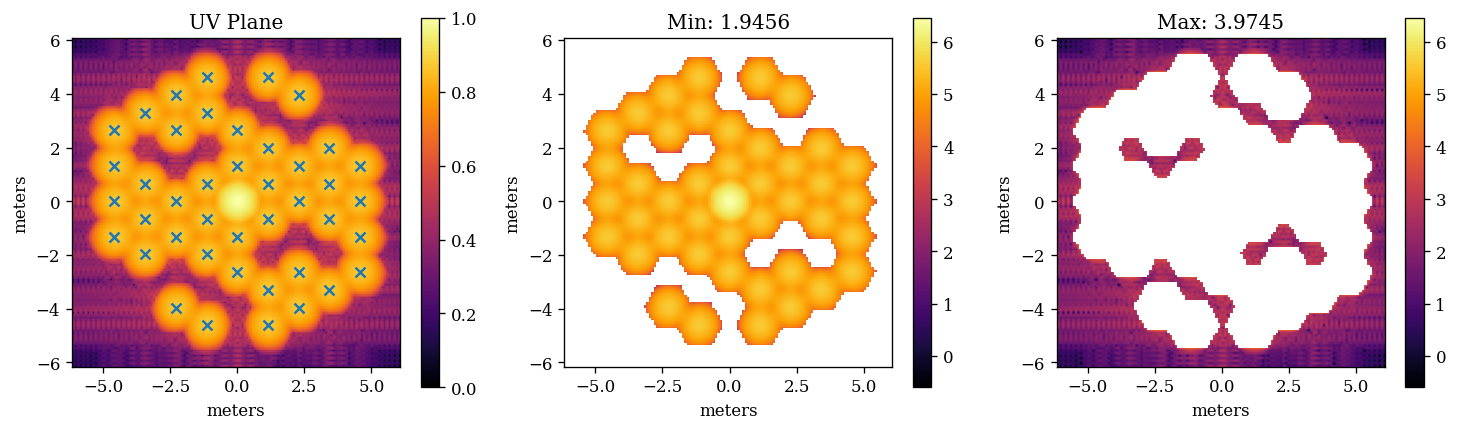

In [14]:
import matplotlib

c = cplx.shape[0] // 2
s = 65
cut = slice(c - s, c + s, 1)

# Get the coordaintes
dx = dlu.arcsec2rad(pscale) / oversample
shifted_coords = osamp_freqs(cplx.shape[0], dx, 1) * wls.mean()
rmin, rmax = shifted_coords[cut].min(), shifted_coords[cut].max()
extent = [rmin, rmax, rmin, rmax]

# Get the amplitude and mask
ampl = (np.abs(cplx))[cut, cut]
mask = (mono_masks.sum(0) > 0)[cut, cut]

# Get the inner and outer values of the mask application
inner = ampl * mask
outer = ampl * np.abs(mask - 1)

# Get the log values
logged = np.where(np.log10(ampl) == -np.inf, np.nan, np.log10(ampl))
vmin, vmax = np.nanmin(logged), np.nanmax(logged)

# Get the min and max values from each
inner_mask_min = np.nanmin(np.log10(inner[np.where(mask)]))
masked_outer = np.where(mask, -np.inf, np.log10(outer))
nand_outer = np.where(masked_outer == -np.inf, np.nan, masked_outer)
outer_mask_max = np.nanmax(nand_outer)


# Plot
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)

plt.title("UV Plane")
plt.imshow(np.abs(cplx)[cut, cut], norm=matplotlib.colors.LogNorm(), extent=extent)
plt.scatter(bls[:, 0], bls[:, 1], marker="x")
plt.xlabel("meters")
plt.ylabel("meters")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title(f"Min: {inner_mask_min:.4f}")
plt.imshow(np.log10(inner), vmin=vmin, vmax=vmax, extent=extent)
plt.xlabel("meters")
plt.ylabel("meters")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title(f"Max: {outer_mask_max:.4f}")
plt.imshow(np.log10(outer), vmin=vmin, vmax=vmax, extent=extent)
plt.ylabel("meters")
plt.xlabel("meters")
plt.colorbar()
plt.show()

Excellent, as we can see the balelines match up with the splodges and the mask cuts them out perfectly.

Now lets have a look at the mask of each baseline pair so we can see the degree of redundancy in the system.

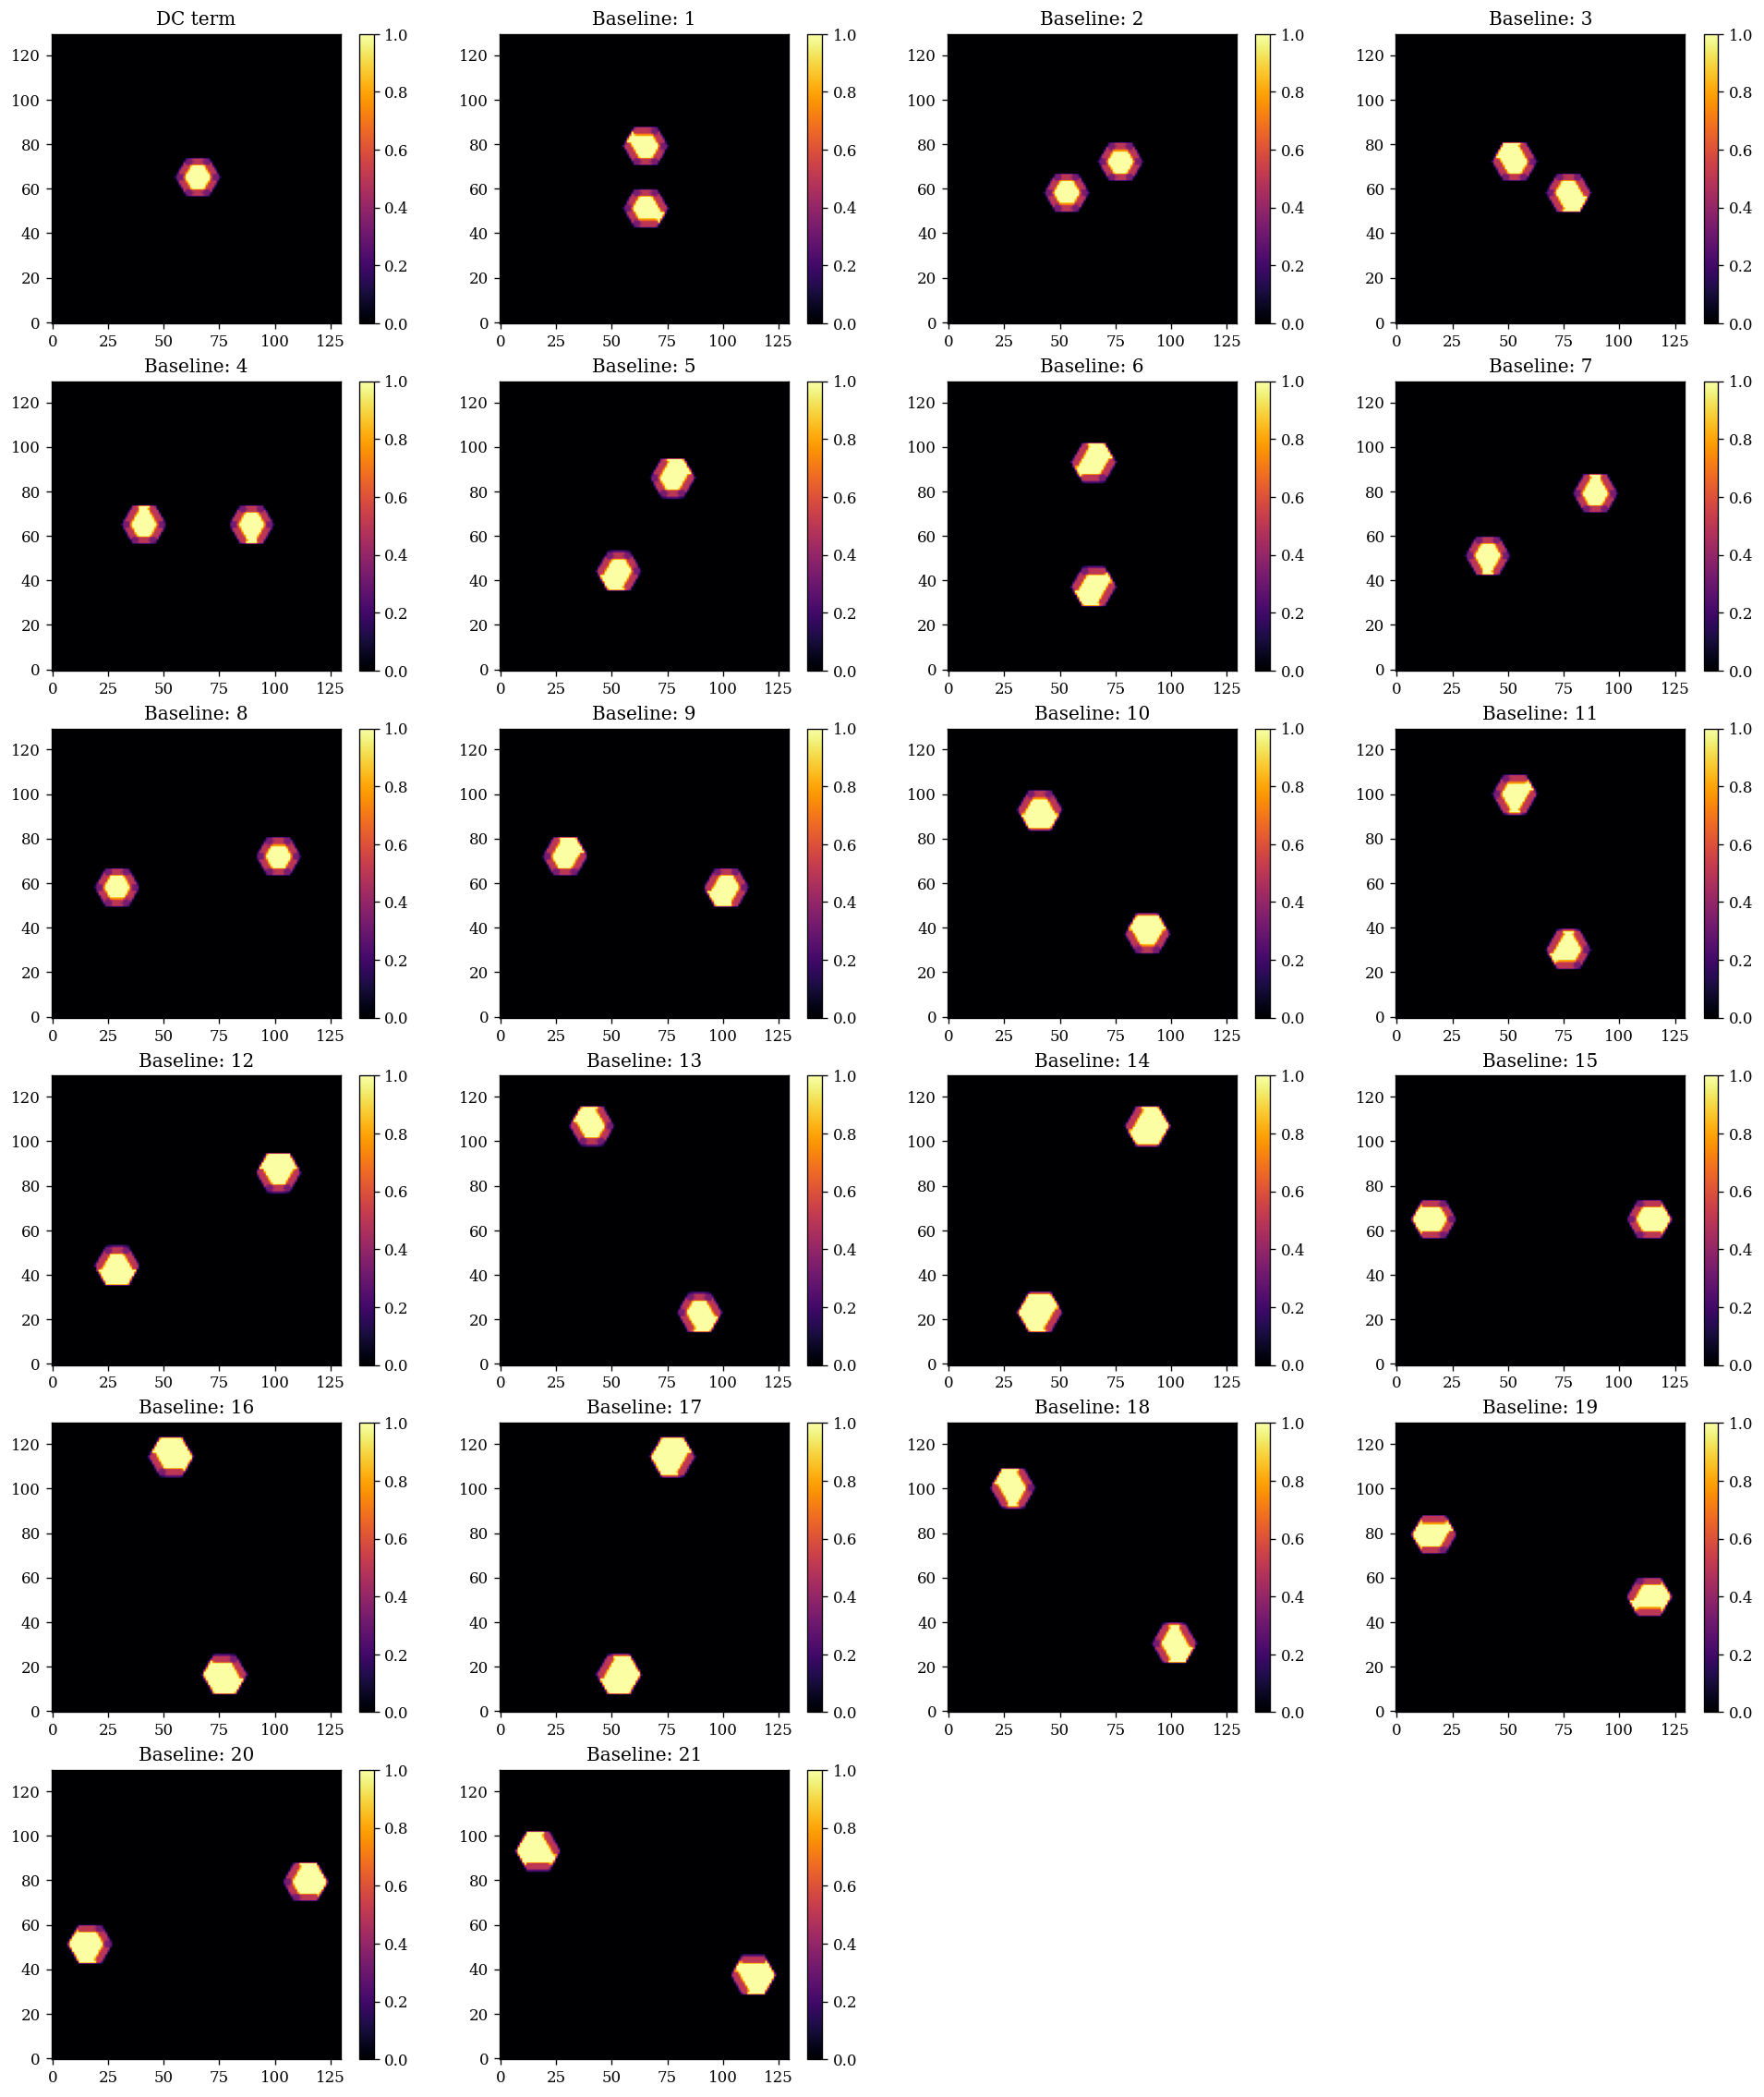

In [15]:
rows, cols = 4, 10
plt.figure(figsize=(5 * rows, 4 * cols))

# Lase value is always the DC term
plt.subplot(cols, rows, 1)
plt.title("DC term")
plt.imshow(mono_masks[0, cut, cut])  # dc term
plt.colorbar()

# The first half is each individual splodge, and the second half its complex conjugate
for i in range(len(mono_masks) // 2):
    m = mono_masks[i + 1]
    m_conj = mono_masks[i + 22]
    mask_in = m + m_conj
    plt.subplot(cols, rows, i + 2)
    plt.title(f"Baseline: {i+1}")
    plt.imshow(mask_in[cut, cut])
    plt.colorbar()
plt.show()

Sick, now lets generate the full mask for each individual wavelength. Note this is a slow operation, but only needs to be done once.

In [16]:
masks = []
for wavelength in tqdm(wls):
    masks.append(
        uv_hex_mask(
            holes,
            f2f,
            wavelength,
            pscale,
            psf_npix,
            oversample,
            pad,
            calc_pad,
        )
    )
masks = np.array(masks)

  0%|          | 0/9 [00:00<?, ?it/s]

# Build the Source

Now that we have our mask, lets build the source and see what we can do

In [17]:
# Enforce initial position
max_idx = np.array(np.where(im == np.nanmax(im))).squeeze()
pos_in = np.roll(tel.psf_pixel_scale * (max_idx - im.shape[0] // 2), 1)

# Enforce initial flux
flux_in = np.array(np.nanmax(im) * ratio)

In [18]:
from lib import UVSource

source = UVSource(wls, masks, position=pos_in, flux=flux_in)

def refresh_model(tel, source, charge_diff=False):
    model = tel.set("source", source)
    model = model.set("flux", np.array(model.get("flux")))
    if not charge_diff:
        new_det = model.detector.remove_layer("ChargeDiffusion")
        model = model.set("detector", new_det)
    return model


model = refresh_model(tel, source)
print(model.source)

UVSource(
  wavelengths=f64[9],
  weights=f64[9],
  position=f64[2],
  flux=f64[],
  mask=f64[9,43,640,640],
  amplitudes=f64[22],
  phases=f64[22],
  pad=2
)


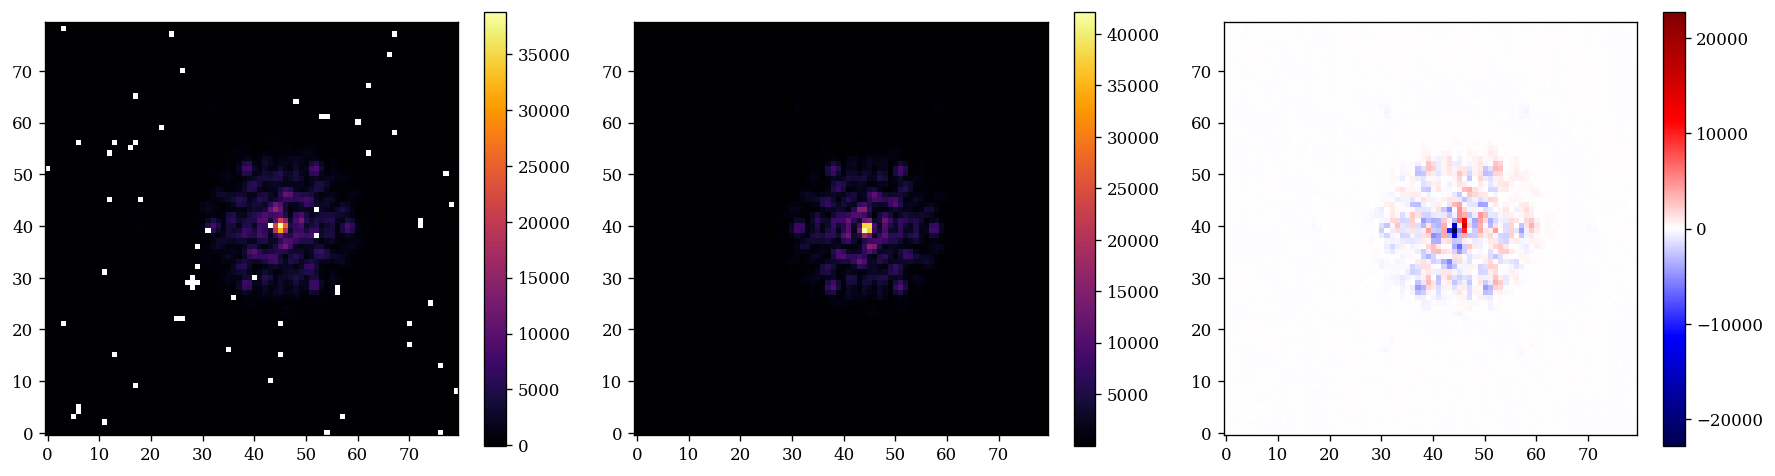

In [19]:
compare(im, model.model())

In [20]:
# Get the data we need
im = np.array(file[1].data).astype(float)
err = np.array(file[2].data).astype(float)
dq = np.array(file[3].data).astype(bool)

# Get the high flux mask
n_mask = 1
sorted = np.sort(im.flatten())
thresh = sorted[~np.isnan(sorted)][-n_mask]
flux_mask = convert_adjacent_to_true(im >= thresh)
im = im.at[np.where(flux_mask)].set(np.nan)

# Build the mask
support_mask = ~np.isnan(im) & ~dq
support = np.array(np.where(support_mask))

# Bind support mask to functions
def set_nan(im):
    return im.at[~support_mask].set(np.nan)

def gettr(im):
    return im[support[0], support[1]]

In [21]:
import jax.scipy as jsp

def like_fn(model, data, sigma):
    psf = model.model()
    return jsp.stats.norm.pdf(gettr(psf), loc=gettr(data), scale=gettr(sigma))

def loglike_fn(model, data, sigma):
    psf = model.model()
    return jsp.stats.norm.logpdf(gettr(psf), loc=gettr(data), scale=gettr(sigma))

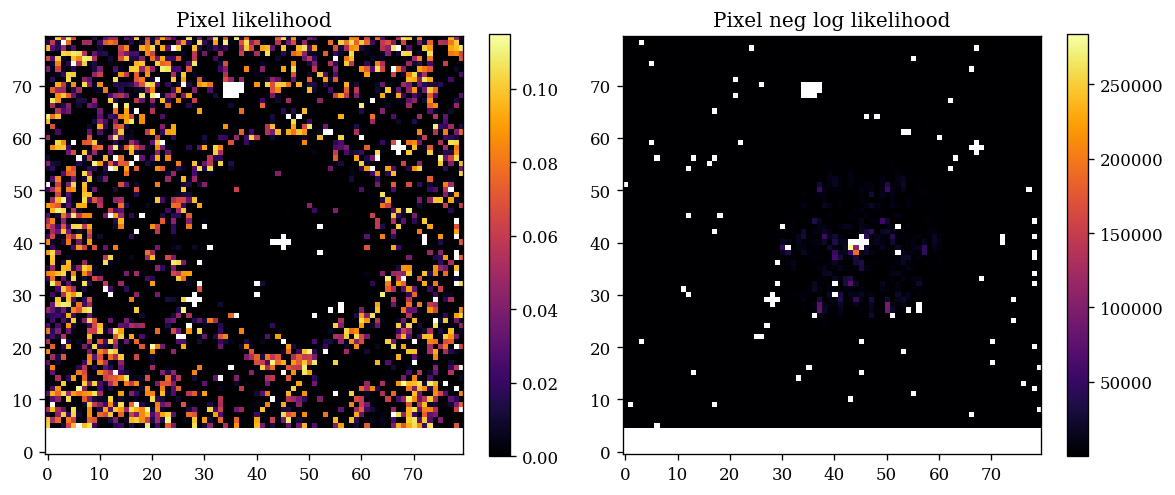

In [22]:
like_px = like_fn(model, im, err)  # pixel likelihood 1d
loglike_px = -loglike_fn(model, im, err)  # pixel likelihood, 1d

like_im = np.ones_like(im) * np.nan
like_im = like_im.at[support[0], support[1]].set(like_px)  # image likelihood (2d)
loglike_im = like_im.at[support[0], support[1]].set(loglike_px)  # image likelihood (2d)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Pixel likelihood")
plt.imshow(like_im)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Pixel neg log likelihood")
plt.imshow(loglike_im)
plt.colorbar()

plt.tight_layout()
plt.show()

In [23]:
params = ["position", "flux", "amplitudes", "phases"]

@zdx.filter_jit
@zdx.filter_value_and_grad(params)
def loss_fn(model, data, err):
    # return like_fn(model, data, err).mean()
    return -loglike_fn(model, data, err).sum()

# Evaluate
loss, grads = loss_fn(model, im, err)

In [24]:
loss, grads.get(params)

(Array(5961872.11186901, dtype=float64),
 [Array([-2.08950221e+08,  1.01531205e+08], dtype=float64),
  Array(0.69655888, dtype=float64),
  Array([-8161168.02915045,   652444.28778699,   221056.91405119,
           397247.69963099,   350634.99151632,   505241.65944619,
           104972.54659596,    75648.70335247,   726525.64324872,
           158401.83797502,   470212.96809528,   266876.16053561,
           476411.46502637,   430130.00333661,   376284.28593209,
           680123.87182393,   230508.52294484,   316964.77476993,
           427839.83919701,   588123.66890383,   364471.49444518,
           341046.69053592], dtype=float64),
  Array([-10400424.85034394,    -12655.02837711,   1086686.88770587,
            258143.22876956,    361973.99924768,   1339343.90788793,
            545431.683771  ,    477584.49166042,   1220627.72254666,
            319341.08357657,   -484521.03090237,    524115.92794055,
           1178802.66253935,   -244771.71925413,    881080.17243084,
           

In [25]:
import optax

optimisers = [
    # Position
    optax.sgd(1e-10),
    # Flux
    optax.sgd(5e6),
    # Amplitudes
    optax.sgd(2.5e-8),
    # Phases
    optax.sgd(5e-8),
]

pos_n = 5
flux_n = 5
ampl_n = 0
phase_n = 90
# vis_n = 50

model = refresh_model(tel, source)
optim, opt_state = zdx.get_optimiser(model, params, optimisers)

loss_scale = 1e-4
loss, _ = loss_fn(model, im, err)
losses, models_out = [], [model]
with tqdm(range(pos_n + flux_n + ampl_n + phase_n), desc="Loss") as t:
    for i in t:
        # calculate the loss and gradient
        loss, grads = loss_fn(model, im, err)
        loss *= loss_scale

        # Manually apply a lr schedule
        if i < pos_n:
            grads = grads.multiply(["flux", "amplitudes", "phases"], 0.0)
        elif i < pos_n + flux_n:
            grads = grads.multiply(["amplitudes", "phases"], 0.0)
        elif i < pos_n + flux_n + ampl_n:
            grads = grads.multiply("phases", 0.0)

        # apply the update
        updates, opt_state = optim.update(grads, opt_state)
        model = zdx.apply_updates(model, updates)

        # Re-normalise the source (weights and phases)
        norm_source = model.source.normalise()
        model = model.set("source", norm_source)

        # save results
        models_out.append(model)
        losses.append(loss)

        t.set_description("Loss %.2f" % (loss))  # update the progress bar

Loss:   0%|          | 0/100 [00:00<?, ?it/s]

In [26]:
loss, grads.get(params)

(Array(26.78771242, dtype=float64),
 [Array([-257476.61729326,  641636.81315924], dtype=float64),
  Array(-4.75560386e-05, dtype=float64),
  Array([   80.21192552,   920.73674014, -1619.04935045, -1586.5740866 ,
         -3942.63234396, -2407.23736715,     9.82001189, -1610.09885133,
         -1460.09953204, -1166.13781653,   -57.03549685,   642.05980957,
         -2346.43188126,  3175.57161123,    88.55616082,  2456.09757927,
           211.79663008, -1554.4871514 ,  1634.33994249,  3535.47667521,
           591.75965364,  4403.3571377 ], dtype=float64),
  Array([ 17583.09202736,  10250.88329141,  11549.603596  ,  17844.00332392,
           9466.67034044,  -1585.21382429,  -3578.00415892,  -1294.58567843,
            781.00831623,  10472.31706121,   1637.62706405,  -6270.09578861,
          -8627.37874405,  -9803.99816622, -27127.45178109,   2819.3370335 ,
         -17235.75474941, -27289.61741262,   4407.64923991,  13901.95856014,
          -9288.55084296,  11386.50129244], dtype=flo

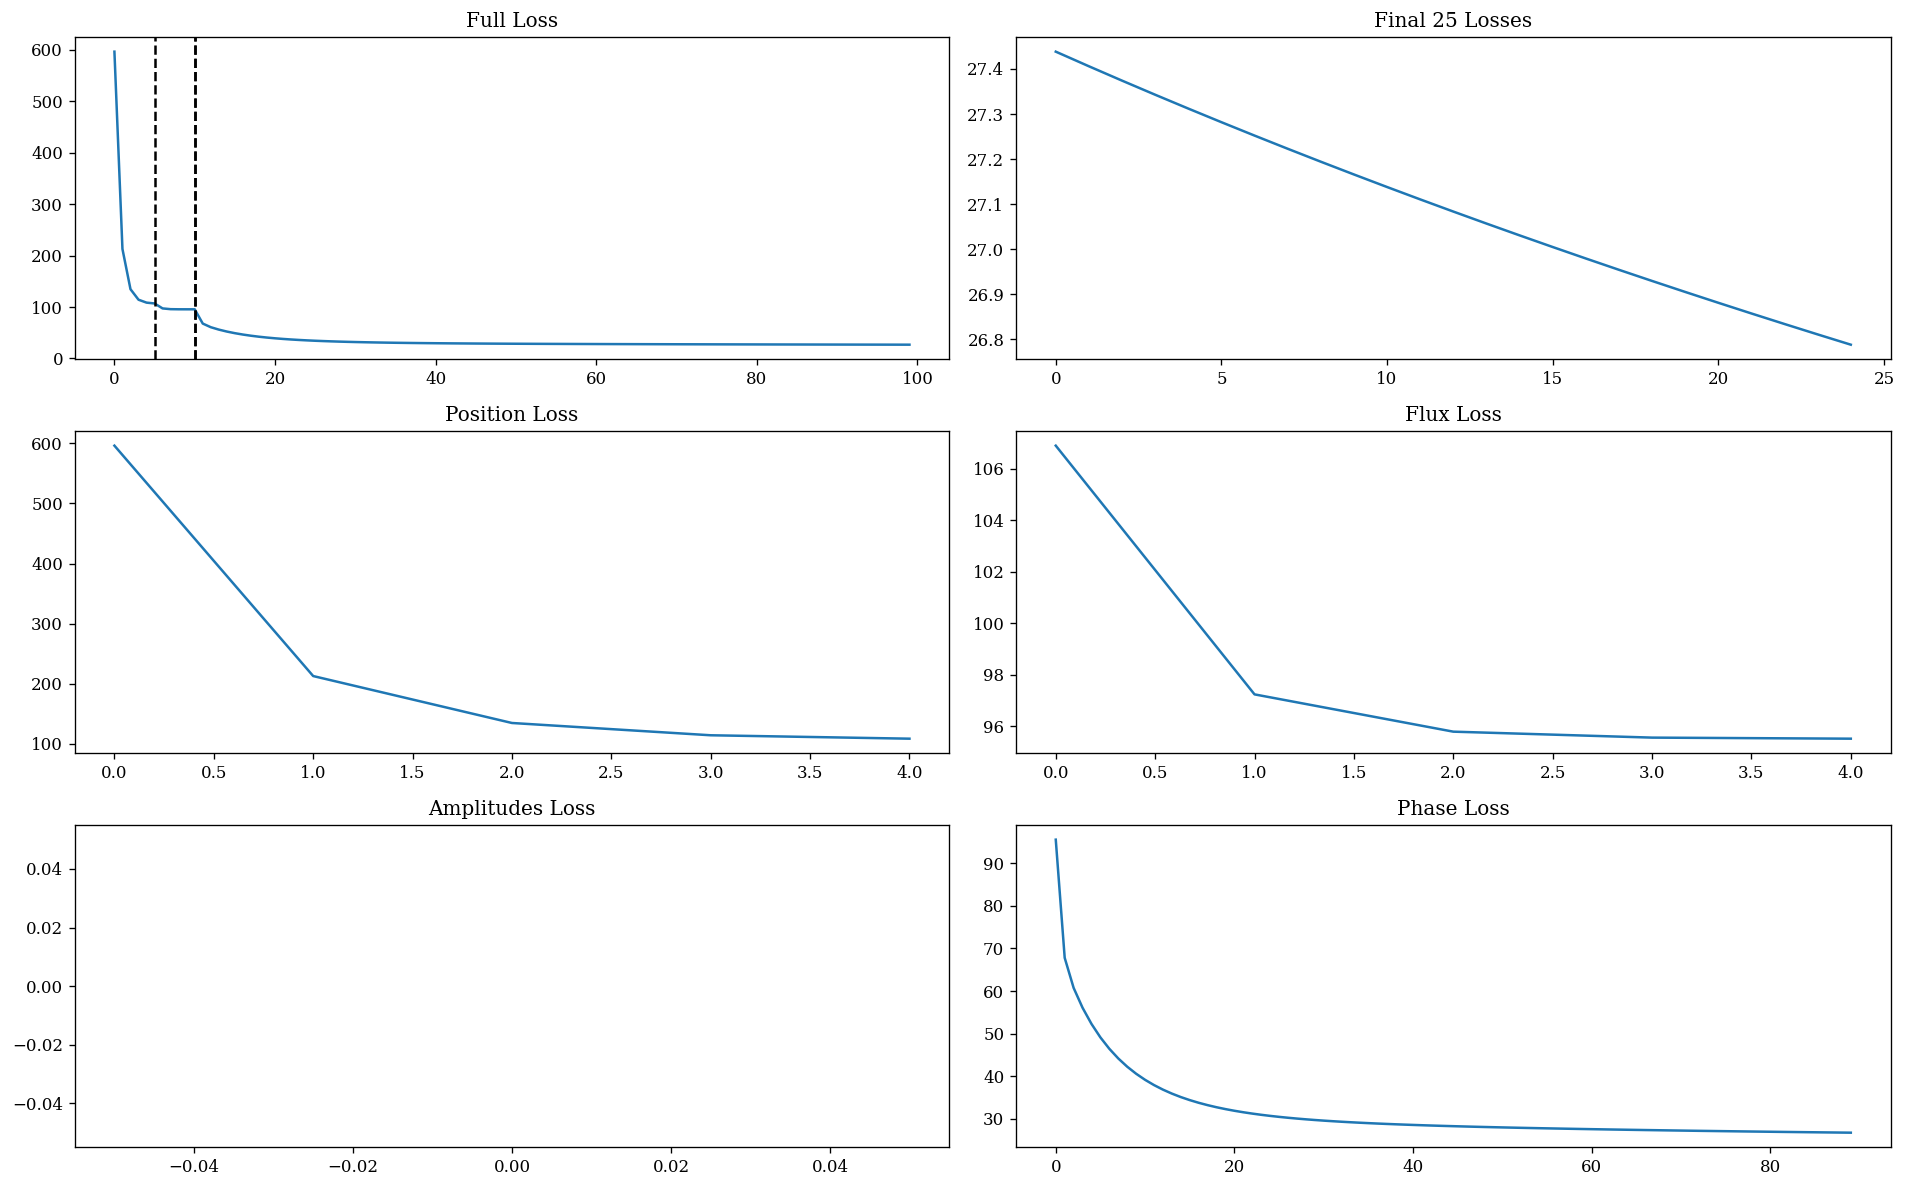

In [27]:
plt.figure(figsize=(16, 10))
plt.subplot(3, 2, 1)
plt.title("Full Loss")
plt.plot(losses)
plt.axvline(pos_n, color="k", linestyle="--")
plt.axvline(pos_n + flux_n, color="k", linestyle="--")
plt.axvline(pos_n + flux_n + ampl_n, color="k", linestyle="--")

k = 25
plt.subplot(3, 2, 2)
plt.title(f"Final {k} Losses")
plt.plot(losses[-k:])

plt.subplot(3, 2, 3)
plt.title("Position Loss")
plt.plot(losses[:pos_n])

plt.subplot(3, 2, 4)
plt.title("Flux Loss")
plt.plot(losses[pos_n : pos_n + flux_n])

plt.subplot(3, 2, 5)
plt.title("Amplitudes Loss")
plt.plot(losses[pos_n + flux_n : pos_n + flux_n + ampl_n])

plt.subplot(3, 2, 6)
plt.title("Phase Loss")
plt.plot(losses[pos_n + flux_n + ampl_n :])

plt.tight_layout()
plt.show()

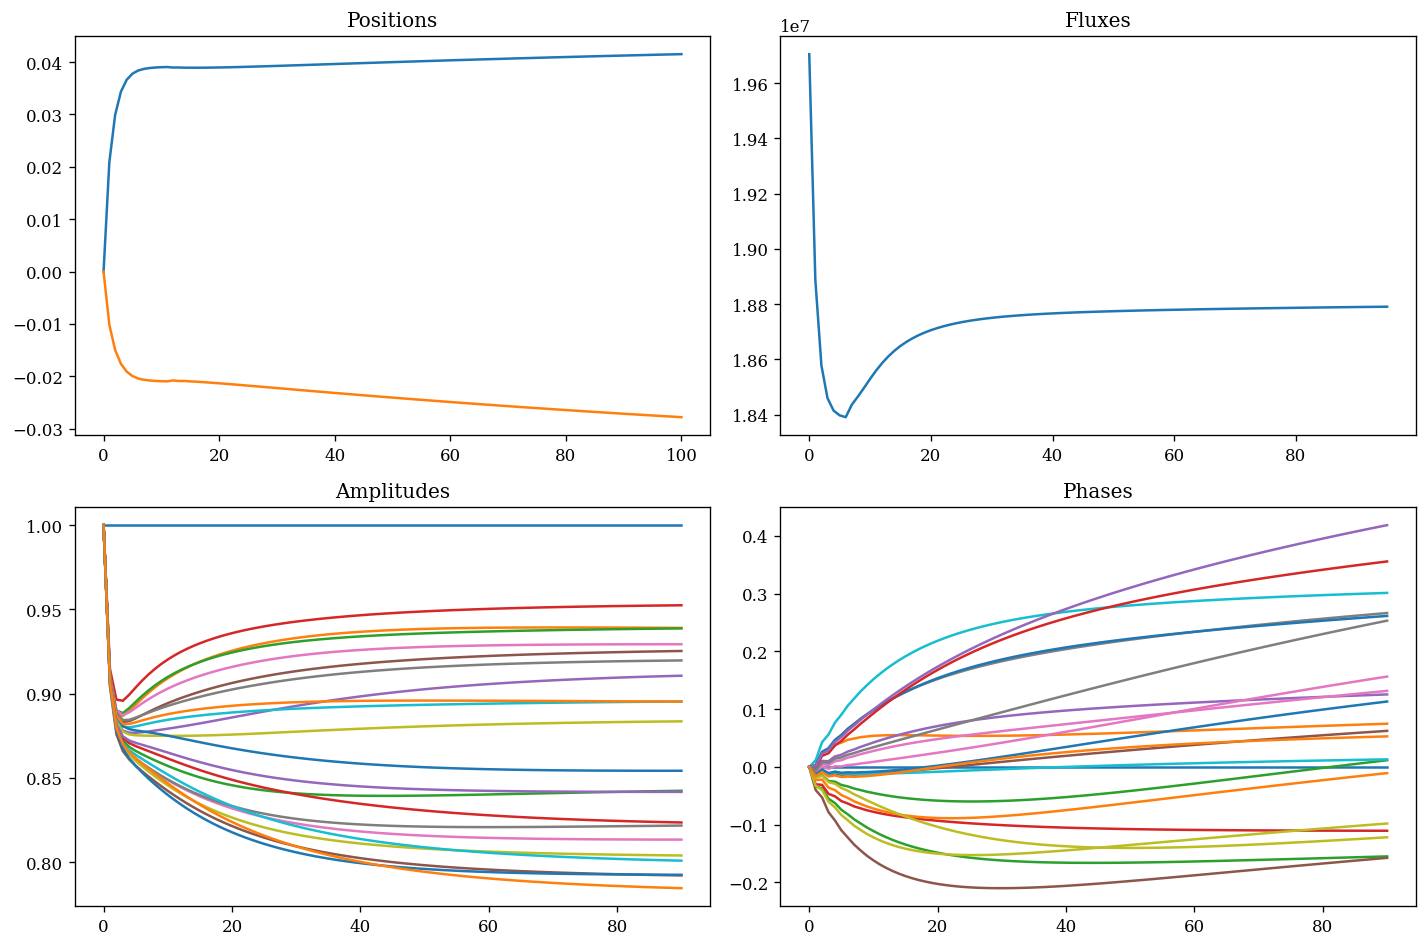

In [28]:
positions = np.array([m.get("position") for m in models_out])
fluxes = np.array([m.get("flux") for m in models_out])
amplitudes = np.array([m.get("amplitudes") for m in models_out])
phases = np.array([m.get("phases") for m in models_out])

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.title("Positions")
plt.plot(positions - positions[0])

plt.subplot(2, 2, 2)
plt.title("Fluxes")
plt.plot(fluxes[pos_n:])

plt.subplot(2, 2, 3)
plt.title("Amplitudes")
plt.plot(amplitudes[pos_n + flux_n :])

plt.subplot(2, 2, 4)
plt.title("Phases")
plt.plot(phases[pos_n + flux_n + ampl_n:])

plt.tight_layout()
plt.show()

Initialisation


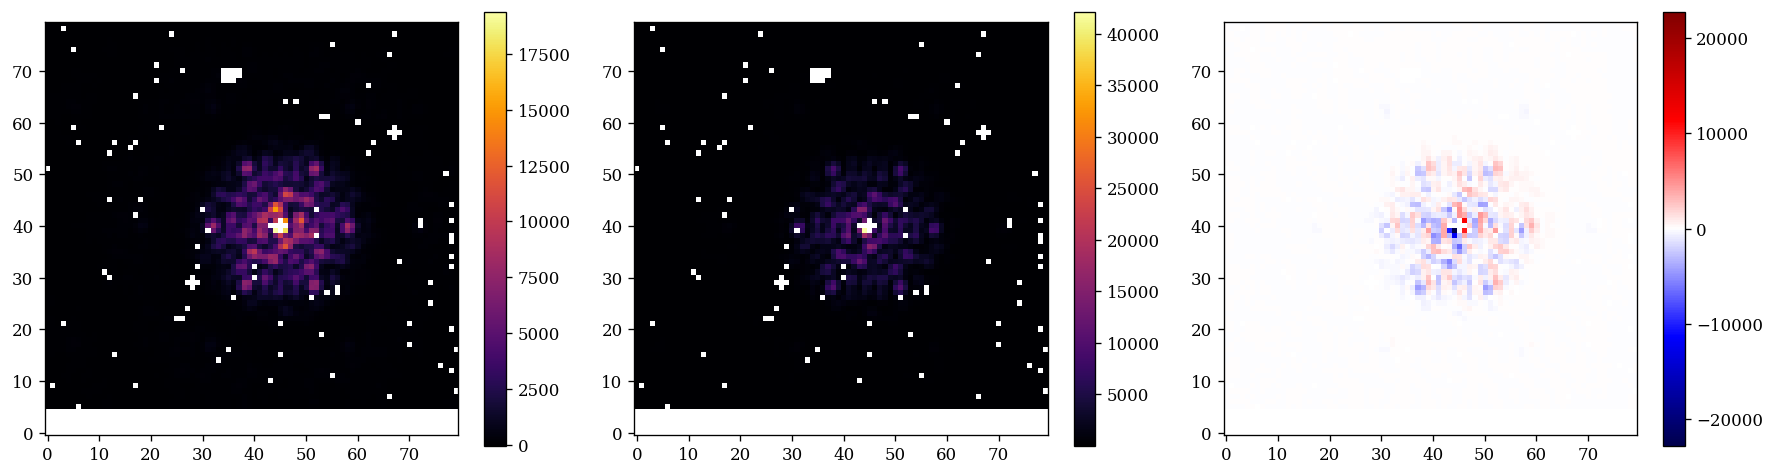

Post Positional Fit


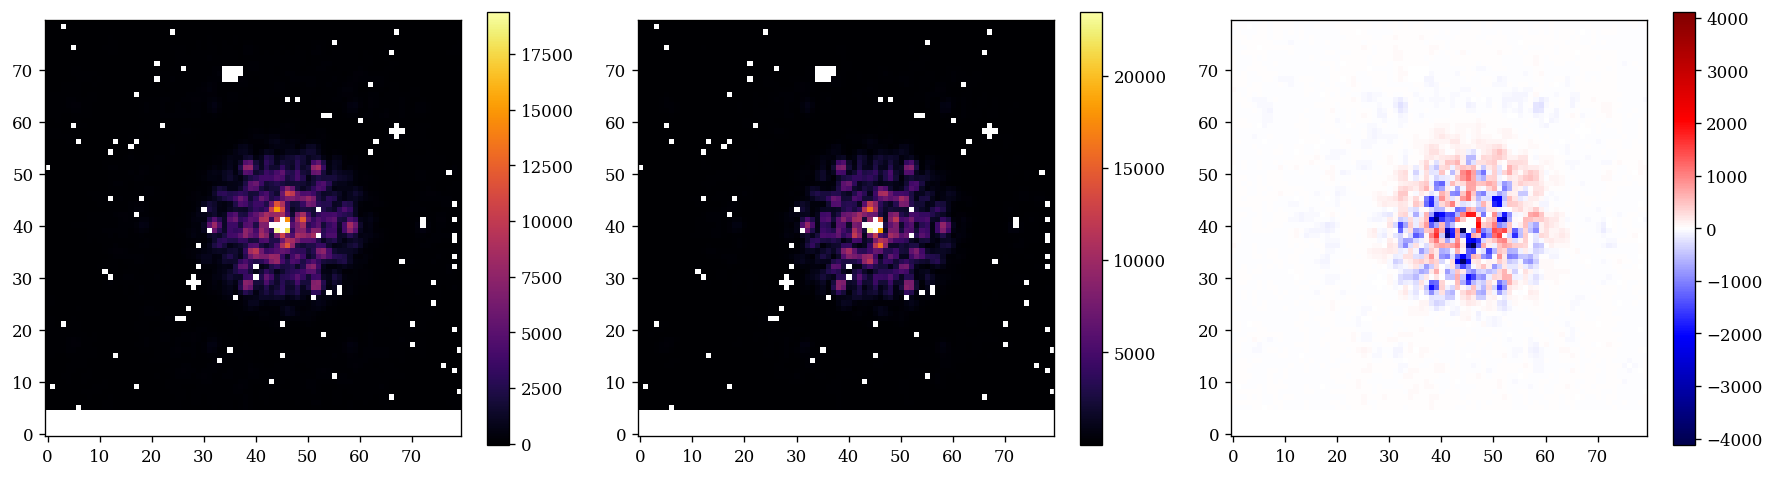

Post Flux Fit


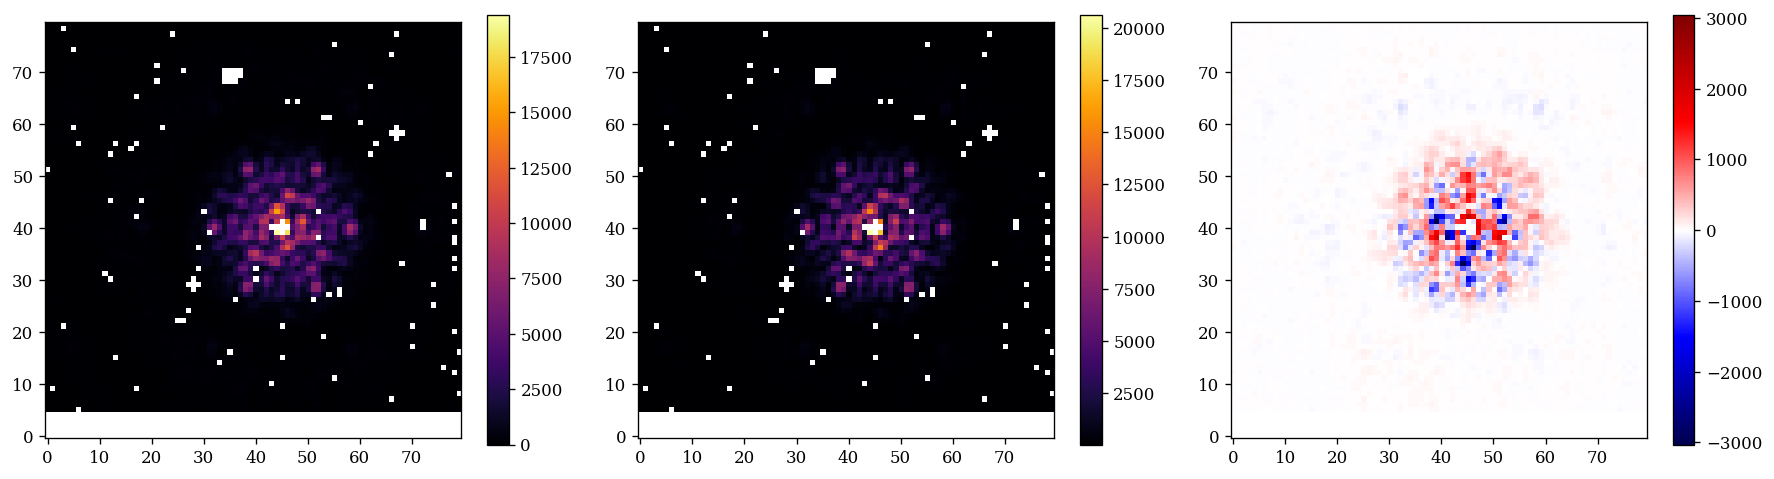

Final Fit


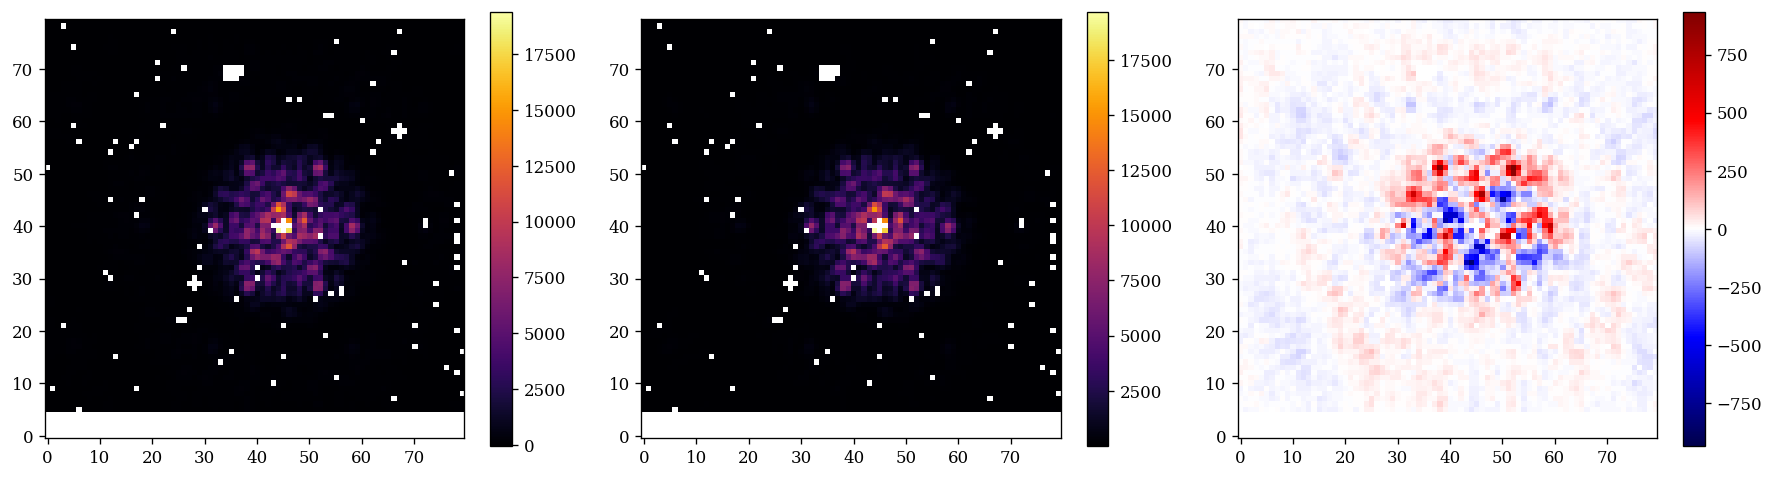

In [29]:
print("Initialisation")
init_psf = refresh_model(tel, source).model()
compare(set_nan(im), set_nan(init_psf))

print("Post Positional Fit")
pos_fit_psf = models_out[pos_n - 1].model()
compare(set_nan(im), set_nan(pos_fit_psf))

print("Post Flux Fit")
flux_fit_psf = models_out[pos_n + flux_n - 1].model()
compare(set_nan(im), set_nan(flux_fit_psf))

print("Final Fit")
final_psf = models_out[-1].model()
compare(set_nan(im), set_nan(final_psf))

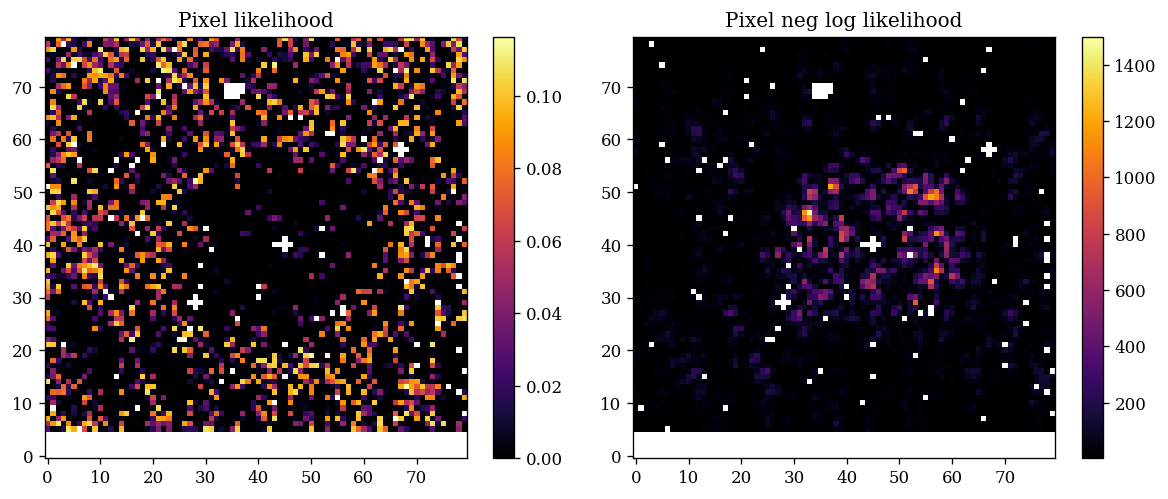

In [30]:
like_px = like_fn(models_out[-1], im, err)  # pixel likelihood 1d
loglike_px = -loglike_fn(models_out[-1], im, err)  # pixel likelihood, 1d

like_im = np.ones_like(im) * np.nan
like_im = like_im.at[support[0], support[1]].set(like_px)  # image likelihood (2d)
loglike_im = like_im.at[support[0], support[1]].set(loglike_px)  # image likelihood (2d)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Pixel likelihood")
plt.imshow(like_im)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Pixel neg log likelihood")
plt.imshow(loglike_im)
plt.colorbar()

plt.tight_layout()
plt.show()

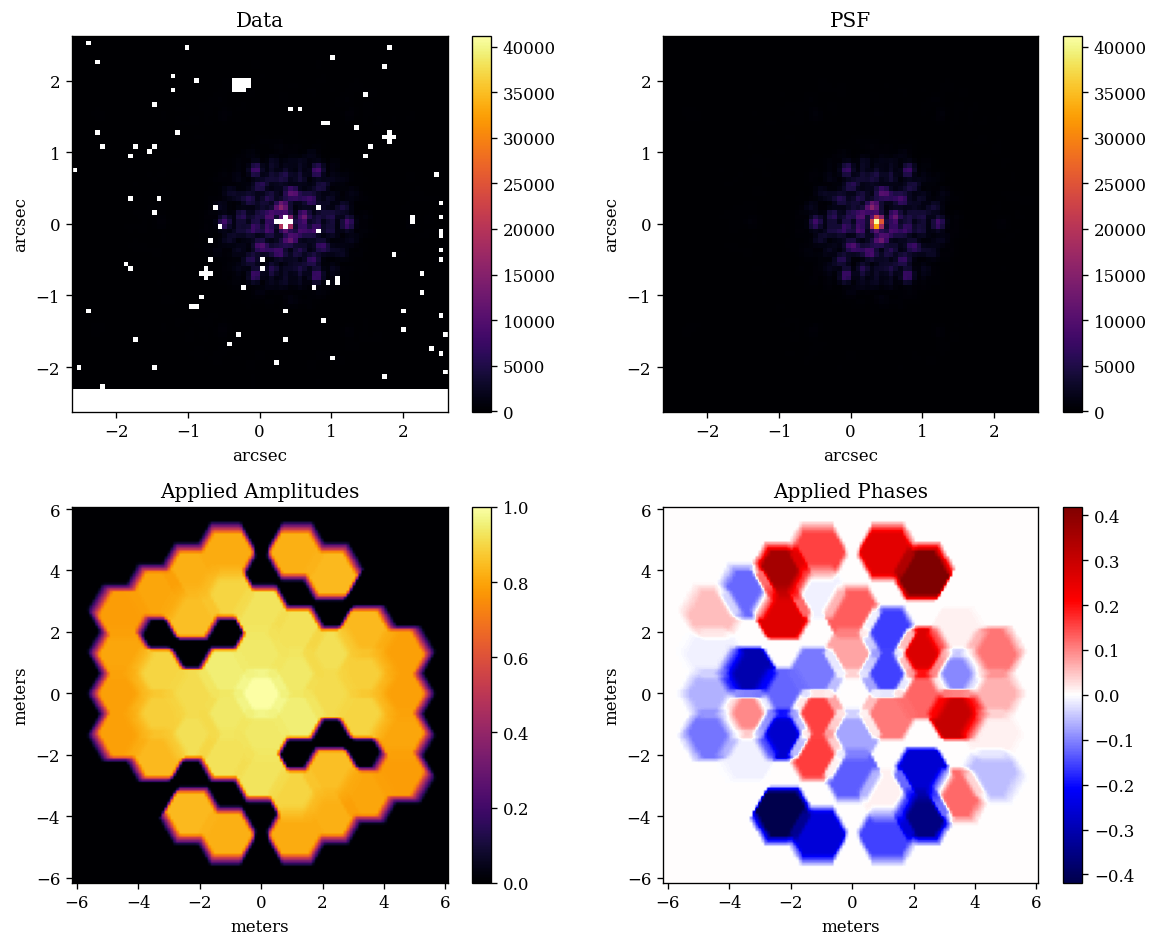

In [31]:
splodges = models_out[-1].source.splodges

c = splodges.shape[-1] // 2
s = 65
cut = slice(c - s, c + s, 1)

r = (model.psf_pixel_scale * model.psf_npixels) / 2
psf_extent = [-r, r, -r, r]

ims= np.array([final_psf, set_nan(im)])
vmin = np.nanmin(ims)
vmax = np.nanmax(ims)

plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.title("Data")
plt.imshow(set_nan(im), extent=psf_extent, vmin=vmin, vmax=vmax)
plt.xlabel("arcsec")
plt.ylabel("arcsec")
plt.colorbar()

plt.subplot(2, 2, 2)
plt.title("PSF")
plt.imshow(final_psf, extent=psf_extent, vmin=vmin, vmax=vmax)
plt.xlabel("arcsec")
plt.ylabel("arcsec")
plt.colorbar()

plt.subplot(2, 2, 3)
plt.title("Applied Amplitudes")
plt.imshow(np.abs(splodges).mean(0)[cut, cut], extent=extent)
plt.colorbar()
plt.xlabel("meters")
plt.ylabel("meters")

plt.subplot(2, 2, 4)
plt.title("Applied Phases")
plt.imshow(np.angle(splodges).mean(0)[cut, cut], extent=extent, cmap="seismic")
plt.colorbar()
plt.xlabel("meters")
plt.ylabel("meters")

plt.tight_layout()
plt.show()

In [56]:
llike_fn = lambda model: -loglike_fn(model, im, err).sum()

# cov_params = ["flux", "position", "amplitudes", "phases"]
cov_params = ["amplitudes", "phases"]
cov = zdx.covariance_matrix(models_out[-1], cov_params, llike_fn)
stds = np.abs(np.diag(cov)) ** 0.5

In [57]:
N = model.source.N + 1 # +1 for dc term
ampl_err = stds[-2 * N : -N]
phase_err = stds[-N:]

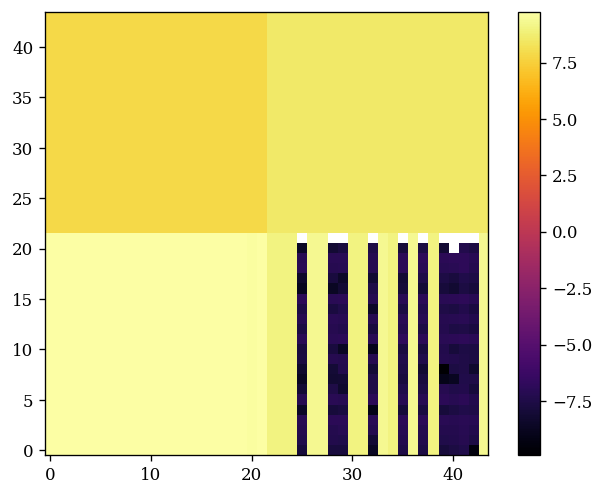

In [58]:
plt.imshow(np.log10(np.abs(cov)))
plt.colorbar()

(21,)
(22,)


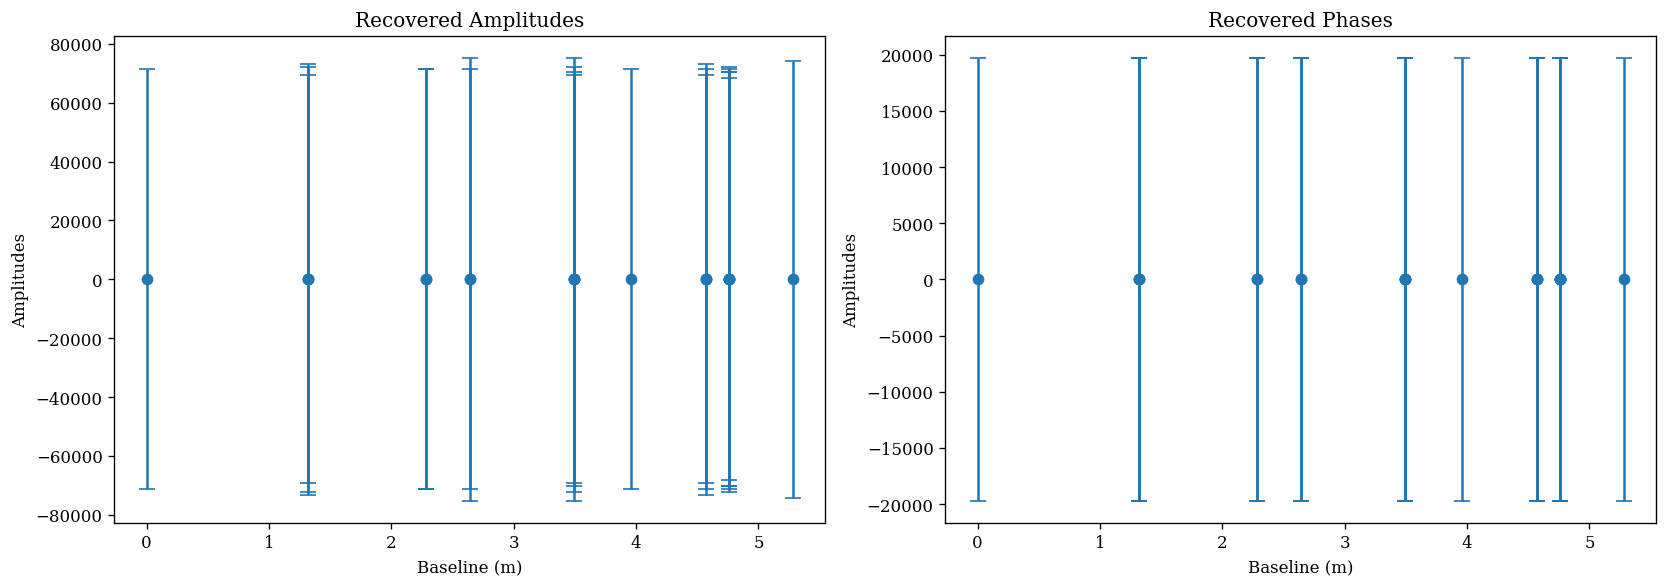

In [65]:
from lib import pairwise_vectors

hbls = pairwise_vectors(holes)
bls_r = np.array(np.hypot(hbls[:, 0], hbls[:, 1]))
print(bls_r.shape)
bls_r = np.concatenate([np.zeros(1), bls_r])
print(bls_r.shape)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.title("Recovered Amplitudes")
plt.errorbar(bls_r, model.amplitudes, yerr=ampl_err, fmt="o", capsize=5)
# plt.errorbar(bls_r[1:], model.amplitudes[1:], yerr=ampl_err[1:], fmt="o", capsize=5)
plt.ylabel("Amplitudes")
plt.xlabel("Baseline (m)")

plt.subplot(1, 2, 2)
plt.title("Recovered Phases")
plt.errorbar(bls_r, model.phases, yerr=phase_err, fmt="o", capsize=5)
plt.ylabel("Amplitudes")
plt.xlabel("Baseline (m)")

plt.tight_layout()
plt.show()

Something seems wrong with the FIM phase values, but not sure whats going on there.